In [1]:
%cd ..

/home/romet/projects/ut/e2e-rally-estonia


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from dataloading.nvidia import NvidiaDataset, NvidiaValidationDataset, Normalize
from pilotnet import PilotnetControl, PilotNetConditional
from metrics.metrics import calculate_open_loop_metrics
from viz.analytics import create_waypoint_error_plot

from metrics.metrics import calculate_trajectory_open_loop_metrics, calculate_open_loop_metrics
from trajectory import calculate_steering_angle
import math

from trainer import ControlTrainer, ConditionalTrainer
from torchvision import transforms

from camera_frame import CameraFrameTransformer


%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def create_model_conditional(model_name, n_branches=3, n_outputs=20):
    model = PilotNetConditional(3, n_branches=n_branches, n_outputs=n_outputs)
    model.load_state_dict(torch.load(f"/home/romet/projects/ut/e2e-rally-estonia/models/{model_name}/best.pt"))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model

def create_model_control(model_name, n_outputs=20):
    model = PilotnetControl(3, n_outputs)
    model.load_state_dict(torch.load(f"/home/romet/projects/ut/e2e-rally-estonia/models/{model_name}/best.pt"))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model

In [13]:
tracks = [
#    "2021-06-09-13-14-51_e2e_rec_ss2",
#    "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
#     "2021-06-09-14-58-11_e2e_rec_ss3",
#     "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
#     "2021-06-09-16-24-59_e2e_rec_ss13",
#     "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
#     "2021-06-10-12-59-59_e2e_ss4",
#     "2021-06-10-13-19-22_e2e_ss4_backwards",
#     "2021-06-10-13-51-34_e2e_ss12",
#     "2021-06-10-14-02-24_e2e_ss12_backwards",
#     "2021-06-10-14-44-24_e2e_ss3_backwards",
#     "2021-06-10-15-03-16_e2e_ss3_backwards",
#     "2021-06-14-11-08-19_e2e_rec_ss14",
#     "2021-06-14-11-22-05_e2e_rec_ss14",
#     "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
#     "2021-09-24-11-19-25_e2e_rec_ss10",
#     "2021-09-24-11-40-24_e2e_rec_ss10_2",
#     "2021-09-24-12-02-32_e2e_rec_ss10_3",
#     "2021-09-24-12-21-20_e2e_rec_ss10_backwards",
#     "2021-09-24-13-39-38_e2e_rec_ss11",
#     "2021-09-30-13-57-00_e2e_rec_ss14",
#     "2021-09-30-15-03-37_e2e_ss14_from_half_way",
#     "2021-09-30-15-20-14_e2e_ss14_backwards",
#     "2021-09-30-15-56-59_e2e_ss14_attempt_2",
#     "2021-10-07-11-05-13_e2e_rec_ss3",
#     "2021-10-07-11-44-52_e2e_rec_ss3_backwards",
#     "2021-10-07-12-54-17_e2e_rec_ss4",
#     "2021-10-07-13-22-35_e2e_rec_ss4_backwards",
#     "2021-10-11-16-06-44_e2e_rec_ss2",
#     "2021-10-11-17-10-23_e2e_rec_last_part",
#     "2021-10-11-17-14-40_e2e_rec_backwards",
#     "2021-10-11-17-20-12_e2e_rec_backwards",
#     "2021-10-20-14-55-47_e2e_rec_vastse_ss13_17",
#     "2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22",
#     "2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back",
#     "2021-10-25-17-31-48_e2e_rec_ss2_arula",
#     "2021-10-25-17-06-34_e2e_rec_ss2_arula_back",
#     "2021-05-28-15-19-48_e2e_sulaoja_20_30",
#     "2021-06-07-14-20-07_e2e_rec_ss6",
#     "2021-06-07-14-06-31_e2e_rec_ss6",
#     "2021-06-07-14-09-18_e2e_rec_ss6",
#     "2021-06-07-14-36-16_e2e_rec_ss6",
#     "2021-09-24-14-03-45_e2e_rec_ss11_backwards",
    "2021-10-26-10-49-06_e2e_rec_ss20_elva",
    "2021-10-26-11-08-59_e2e_rec_ss20_elva_back",
    "2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back",
    "2021-10-11-14-50-59_e2e_rec_vahi",
    "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
    
]

In [14]:
root_path = Path("/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021")
n_waypoints = 10
n_branches = 3
tr = transforms.Compose([Normalize()])
dataset_name = tracks[1]
dataset = NvidiaDataset([root_path / dataset_name], transform=tr, n_branches=n_branches,
                            output_modality="waypoints", n_waypoints=n_waypoints)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=16)
conditional_trainer = ConditionalTrainer()
conditional_model = create_model_conditional('20220528003119_waypoints-center-cam', n_branches=3, n_outputs=20)
predicted_waypoints = conditional_trainer.predict(conditional_model, dataloader)
true_waypoints = dataset.get_waypoints()
trajectory_metrics = calculate_trajectory_open_loop_metrics(predicted_waypoints, true_waypoints, fps=30)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

In [15]:
trajectory_metrics

{'first_wp_mae': 0.143492810386663,
 'first_wp_rmse': 0.18273109914660093,
 'first_wp_max': 1.0283037787889115,
 'first_wp_whiteness': 0.9514921,
 'first_wp_expert_whiteness': 0.1525434988830065,
 'sixth_wp_mae': 0.48715350375072625,
 'sixth_wp_whiteness': 5.221166,
 'sixth_wp_expert_whiteness': 1.632353459345258,
 'last_wp_mae': 1.2165482809732489,
 'last_wp_rmse': 2.418229939688393,
 'last_wp_max': 24.24644282173112,
 'last_wp_whiteness': 14.276096,
 'last_wp_expert_whiteness': 3.04398024363259}

In [18]:
true_steering_angles = dataset.frames.steering_angle.to_numpy()
pred_steering_angles = []
transformer = CameraFrameTransformer()
for wp in tqdm(predicted_waypoints):
    steering_angle_wp = [0.0, 0.0]
    steering_angle_wp.extend(wp[:4])
    wp_baselink = transformer.transform_waypoints(steering_angle_wp, "interfacea_link2")
    pred_steering_angles.append(calculate_steering_angle(wp_baselink, ref_distance=9.5))

fps = 30

steering_metrics = calculate_open_loop_metrics(np.array(pred_steering_angles), true_steering_angles, fps=fps)

  0%|          | 0/33000 [00:00<?, ?it/s]

In [19]:
trajectory_metrics.update(steering_metrics)
trajectory_metrics

{'first_wp_mae': 0.143492810386663,
 'first_wp_rmse': 0.18273109914660093,
 'first_wp_max': 1.0283037787889115,
 'first_wp_whiteness': 0.9514921,
 'first_wp_expert_whiteness': 0.1525434988830065,
 'sixth_wp_mae': 0.48715350375072625,
 'sixth_wp_whiteness': 5.221166,
 'sixth_wp_expert_whiteness': 1.632353459345258,
 'last_wp_mae': 1.2165482809732489,
 'last_wp_rmse': 2.418229939688393,
 'last_wp_max': 24.24644282173112,
 'last_wp_whiteness': 14.276096,
 'last_wp_expert_whiteness': 3.04398024363259,
 'mae': 13.087206809847677,
 'rmse': 27.47130154837776,
 'max': 441.531984099373,
 'whiteness': 149.2463790956363,
 'expert_whiteness': 24.16830026201153}

In [20]:
def calculate_waypoint_metrics(model, trainer, dataset_name, n_waypoints=10, n_branches=3):
    root_path = Path("/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021")
    tr = transforms.Compose([Normalize()])
    dataset = NvidiaDataset([root_path / dataset_name], transform=tr, n_branches=n_branches,
                            output_modality="waypoints", n_waypoints=n_waypoints)
    #dataset = NvidiaValidationDataset(root_path, output_modality="waypoints", transform=tr,
    #                        n_waypoints=n_waypoints, n_branches=n_branches)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=16)
    predicted_waypoints = trainer.predict(model, dataloader)
    true_waypoints = dataset.get_waypoints()
    trajectory_metrics = calculate_trajectory_open_loop_metrics(predicted_waypoints, true_waypoints, fps=30)
    
    true_steering_angles = dataset.frames.steering_angle.to_numpy()
    pred_steering_angles = []
    
    transformer = CameraFrameTransformer()
    
    for wp in tqdm(predicted_waypoints):
        steering_angle_wp = [0.0, 0.0]
        steering_angle_wp.extend(wp[:4])
        wp_baselink = transformer.transform_waypoints(steering_angle_wp, "interfacea_link2")
        pred_steering_angles.append(calculate_steering_angle(wp_baselink, ref_distance=9.5))
    
    steering_metrics = calculate_open_loop_metrics(np.array(pred_steering_angles), true_steering_angles, fps=30)
    
    trajectory_metrics.update(steering_metrics)
    
    return trajectory_metrics

In [21]:
import traceback

def calculate_tracks_metrics(model, trainer, tracks, n_branches, n_waypoints):
    results = []
    for track in tracks:
        try:
            metrics = calculate_waypoint_metrics(model, trainer, track, n_waypoints=n_waypoints, n_branches=n_branches)
            metrics['track'] = track
            results.append(metrics)
        except Exception as e:
            traceback.print_exc()
            print(f"Cannot calculate metrics for {track}")
            print(e)
        

    df = pd.DataFrame(data=results)
    df.set_index('track', inplace=True)
    return df

In [22]:
tracks = [
#    "2021-06-09-13-14-51_e2e_rec_ss2",
#    "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
#     "2021-06-09-14-58-11_e2e_rec_ss3",
#     "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
#     "2021-06-09-16-24-59_e2e_rec_ss13",
#     "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
#     "2021-06-10-12-59-59_e2e_ss4",
#     "2021-06-10-13-19-22_e2e_ss4_backwards",
#     "2021-06-10-13-51-34_e2e_ss12",
#     "2021-06-10-14-02-24_e2e_ss12_backwards",
#     "2021-06-10-14-44-24_e2e_ss3_backwards",
#     "2021-06-10-15-03-16_e2e_ss3_backwards",
#     "2021-06-14-11-08-19_e2e_rec_ss14",
#     "2021-06-14-11-22-05_e2e_rec_ss14",
#     "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
#     "2021-09-24-11-19-25_e2e_rec_ss10",
#     "2021-09-24-11-40-24_e2e_rec_ss10_2",
#     "2021-09-24-12-02-32_e2e_rec_ss10_3",
#     "2021-09-24-12-21-20_e2e_rec_ss10_backwards",
#     "2021-09-24-13-39-38_e2e_rec_ss11",
#     "2021-09-30-13-57-00_e2e_rec_ss14",
#     "2021-09-30-15-03-37_e2e_ss14_from_half_way",
#     "2021-09-30-15-20-14_e2e_ss14_backwards",
#     "2021-09-30-15-56-59_e2e_ss14_attempt_2",
#     "2021-10-07-11-05-13_e2e_rec_ss3",
#     "2021-10-07-11-44-52_e2e_rec_ss3_backwards",
#     "2021-10-07-12-54-17_e2e_rec_ss4",
#     "2021-10-07-13-22-35_e2e_rec_ss4_backwards",
#     "2021-10-11-16-06-44_e2e_rec_ss2",
#     "2021-10-11-17-10-23_e2e_rec_last_part",
#     "2021-10-11-17-14-40_e2e_rec_backwards",
#     "2021-10-11-17-20-12_e2e_rec_backwards",
#     "2021-10-20-14-55-47_e2e_rec_vastse_ss13_17",
#     "2021-10-20-13-57-51_e2e_rec_neeruti_ss19_22",
#     "2021-10-20-14-15-07_e2e_rec_neeruti_ss19_22_back",
#     "2021-10-25-17-31-48_e2e_rec_ss2_arula",
#     "2021-10-25-17-06-34_e2e_rec_ss2_arula_back",
     "2021-05-28-15-19-48_e2e_sulaoja_20_30",
     "2021-06-07-14-20-07_e2e_rec_ss6",
     "2021-06-07-14-06-31_e2e_rec_ss6",
     "2021-06-07-14-09-18_e2e_rec_ss6",
     "2021-06-07-14-36-16_e2e_rec_ss6",
     "2021-09-24-14-03-45_e2e_rec_ss11_backwards",
    "2021-10-26-10-49-06_e2e_rec_ss20_elva",
    "2021-10-26-11-08-59_e2e_rec_ss20_elva_back",
    "2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back",
    "2021-10-11-14-50-59_e2e_rec_vahi",
    "2021-10-14-13-08-51_e2e_rec_vahi_backwards"
    
]

In [23]:
# winter_tracks = [
#     "2022-01-28-10-21-14_e2e_rec_peipsiaare_forward",
#     "2022-01-28-12-46-59_e2e_rec_peipsiaare_backward",
#     "2022-01-14-10-05-16_e2e_rec_raanitsa_forward",
#     "2022-01-14-10-50-05_e2e_rec_raanitsa_backward",
#     "2022-01-14-11-54-33_e2e_rec_kambja_forward2",
#     "2022-01-14-12-21-40_e2e_rec_kambja_forward2_continue",
#     "2022-01-14-13-09-05_e2e_rec_kambja_backward",
#     "2022-01-14-13-18-36_e2e_rec_kambja_backward_continue",
#     "2022-01-14-12-35-13_e2e_rec_neeruti_forward",
#     "2022-01-14-12-45-51_e2e_rec_neeruti_backward",
#     "2022-01-18-13-03-03_e2e_rec_arula_backward",
#     "2022-01-18-13-43-33_e2e_rec_otepaa_forward",
#     "2022-01-18-13-52-35_e2e_rec_otepaa_forward",
#     "2022-01-18-13-56-22_e2e_rec_otepaa_forward",
#     "2022-01-18-14-12-14_e2e_rec_otepaa_backward",
#     "2022-01-18-15-20-35_e2e_rec_kanepi_forward",
#     "2022-01-18-15-49-26_e2e_rec_kanepi_backwards",
#     "2022-01-18-12-37-01_e2e_rec_arula_forward",
#     "2022-01-18-12-47-32_e2e_rec_arula_forward_continue",
#     "2022-01-28-14-47-23_e2e_rec_elva_forward",
#     "2022-01-28-15-09-01_e2e_rec_elva_backward",
#     "2022-01-25-15-25-15_e2e_rec_vahi_forward",
#     "2022-01-25-15-34-01_e2e_rec_vahi_backwards",
# ]

In [24]:
conditional_model = create_model_conditional('20220607020435_waypoints-all-20', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
model1_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks, n_branches=3, n_waypoints=10)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10547, filtered=161


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/10547 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25710, filtered=127


  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/25710 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=2802, filtered=201


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4474, filtered=78


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4474 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25255, filtered=114


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/25255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=32738, filtered=307


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/32738 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26498, filtered=265


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/26498 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=15196, filtered=6017


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/15196 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13284, filtered=158


  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/13284 [00:00<?, ?it/s]

In [25]:
conditional_model = create_model_conditional('20220607113322_waypoints-all-10', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
model2_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks, n_branches=3, n_waypoints=10)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10547, filtered=161


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/10547 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25710, filtered=127


  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/25710 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=2802, filtered=201


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4474, filtered=78


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4474 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25255, filtered=114


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/25255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=32738, filtered=307


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/32738 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26498, filtered=265


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/26498 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=15196, filtered=6017


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/15196 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13284, filtered=158


  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/13284 [00:00<?, ?it/s]

In [26]:
conditional_model = create_model_conditional('20220607094616_waypoints-all-33', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
model3_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks, n_branches=3, n_waypoints=10)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10547, filtered=161


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/10547 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25710, filtered=127


  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/25710 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=2802, filtered=201


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4474, filtered=78


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4474 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25255, filtered=114


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/25255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=32738, filtered=307


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/32738 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26498, filtered=265


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/26498 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=15196, filtered=6017


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/15196 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13284, filtered=158


  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/13284 [00:00<?, ?it/s]

In [27]:
conditional_model = create_model_conditional('20220528003119_waypoints-center-cam', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
model4_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks, n_branches=3, n_waypoints=10)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10547, filtered=161


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/10547 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25710, filtered=127


  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/25710 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=2802, filtered=201


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4474, filtered=78


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4474 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25255, filtered=114


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/25255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=32738, filtered=307


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/32738 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26498, filtered=265


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/26498 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=15196, filtered=6017


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/15196 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13284, filtered=158


  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/13284 [00:00<?, ?it/s]

In [28]:
conditional_model = create_model_conditional('20220525165113_waypoints-center-cam', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
model5_df = calculate_tracks_metrics(conditional_model, conditional_trainer, tracks, n_branches=3, n_waypoints=10)

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10547, filtered=161


  0%|          | 0/330 [00:00<?, ?it/s]

  0%|          | 0/10547 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25710, filtered=127


  0%|          | 0/804 [00:00<?, ?it/s]

  0%|          | 0/25710 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=2802, filtered=201


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4474, filtered=78


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4474 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25255, filtered=114


  0%|          | 0/790 [00:00<?, ?it/s]

  0%|          | 0/25255 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=32738, filtered=307


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/32738 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33000, filtered=281


  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/33000 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26498, filtered=265


  0%|          | 0/829 [00:00<?, ?it/s]

  0%|          | 0/26498 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_vahi: lenght=15196, filtered=6017


  0%|          | 0/475 [00:00<?, ?it/s]

  0%|          | 0/15196 [00:00<?, ?it/s]

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-10-14-13-08-51_e2e_rec_vahi_backwards: lenght=13284, filtered=158


  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/13284 [00:00<?, ?it/s]

In [29]:
filtered_columns = ["first_wp_mae", "last_wp_mae", "first_wp_max", "last_wp_max", "mae", "max", "whiteness"]
model3_df[filtered_columns]

,first_wp_mae,last_wp_mae,first_wp_max,last_wp_max,mae,max,whiteness
track,,,,,,,
2021-05-28-15-19-48_e2e_sulaoja_20_30,0.181326,1.275346,1.062683,37.877231,13.260331,390.201376,186.031895
2021-06-07-14-20-07_e2e_rec_ss6,0.197320,1.321995,1.388290,36.502696,14.145135,469.592482,168.598101
2021-06-07-14-06-31_e2e_rec_ss6,0.219000,0.852785,1.300613,8.046153,11.735529,96.278537,107.417614
2021-06-07-14-09-18_e2e_rec_ss6,0.220142,1.307618,1.586725,49.082984,30.381700,586.778720,324.381127
2021-06-07-14-36-16_e2e_rec_ss6,0.194187,1.366075,1.174132,27.673034,13.818133,546.572679,147.213248
2021-09-24-14-03-45_e2e_rec_ss11_backwards,0.164712,1.988623,1.897639,61.401265,15.619493,1097.032730,407.219315
2021-10-26-10-49-06_e2e_rec_ss20_elva,0.173102,1.202589,0.915566,29.080075,14.248673,357.117667,125.283025
2021-10-26-11-08-59_e2e_rec_ss20_elva_back,0.172811,1.242186,1.122953,29.005371,14.939088,413.758585,134.033794
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,0.199371,2.801887,2.523601,48.193391,22.962536,559.582080,298.216325


In [30]:
model1_df[filtered_columns]

,first_wp_mae,last_wp_mae,first_wp_max,last_wp_max,mae,max,whiteness
track,,,,,,,
2021-05-28-15-19-48_e2e_sulaoja_20_30,0.142732,1.318042,0.838595,36.489025,9.428750,328.432922,156.666692
2021-06-07-14-20-07_e2e_rec_ss6,0.149307,1.359430,1.202407,49.896656,10.867701,435.248687,154.922428
2021-06-07-14-06-31_e2e_rec_ss6,0.181234,0.972684,1.212820,8.938902,8.541485,91.317124,90.344632
2021-06-07-14-09-18_e2e_rec_ss6,0.162618,1.513018,1.128061,34.586177,25.603091,432.339712,176.284272
2021-06-07-14-36-16_e2e_rec_ss6,0.158355,1.393740,0.946813,29.219137,11.117679,490.917830,143.140145
2021-09-24-14-03-45_e2e_rec_ss11_backwards,0.145733,1.947503,1.747846,52.083460,12.817935,1204.631104,640.259653
2021-10-26-10-49-06_e2e_rec_ss20_elva,0.129351,1.197445,0.969634,31.645976,11.551411,340.204695,111.858561
2021-10-26-11-08-59_e2e_rec_ss20_elva_back,0.126215,1.300876,1.224794,33.951436,12.349386,313.130757,130.776671
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,0.163886,2.508934,2.321566,45.951843,20.924336,415.171680,236.988230


In [31]:
model2_df[filtered_columns]

,first_wp_mae,last_wp_mae,first_wp_max,last_wp_max,mae,max,whiteness
track,,,,,,,
2021-05-28-15-19-48_e2e_sulaoja_20_30,0.138553,1.328130,0.911654,34.382730,10.205378,348.525837,144.790589
2021-06-07-14-20-07_e2e_rec_ss6,0.136928,1.399407,1.657239,59.647655,10.120574,532.020160,153.403975
2021-06-07-14-06-31_e2e_rec_ss6,0.163585,0.875402,0.984162,9.506336,7.011829,67.686692,72.248951
2021-06-07-14-09-18_e2e_rec_ss6,0.177940,1.420132,1.896553,45.155483,28.625967,882.035228,600.955679
2021-06-07-14-36-16_e2e_rec_ss6,0.146864,1.385815,1.357354,31.535782,10.100038,524.189487,125.611039
2021-09-24-14-03-45_e2e_rec_ss11_backwards,0.142487,2.002464,2.282398,54.607980,13.282843,1054.772300,669.229726
2021-10-26-10-49-06_e2e_rec_ss20_elva,0.115553,1.282771,1.550003,56.748278,11.425847,669.093933,180.250312
2021-10-26-11-08-59_e2e_rec_ss20_elva_back,0.115943,1.274868,1.739351,33.295361,12.303370,493.918049,127.141438
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,0.140902,2.644264,2.391713,52.916649,21.863141,1218.375069,404.921142


In [32]:
model4_df[filtered_columns]

,first_wp_mae,last_wp_mae,first_wp_max,last_wp_max,mae,max,whiteness
track,,,,,,,
2021-05-28-15-19-48_e2e_sulaoja_20_30,0.153905,1.318806,1.441440,36.120418,10.044284,340.081276,194.547825
2021-06-07-14-20-07_e2e_rec_ss6,0.165192,1.314375,1.515148,29.135115,11.502839,486.178150,171.596979
2021-06-07-14-06-31_e2e_rec_ss6,0.173082,1.037280,1.368381,8.086711,7.380554,80.269606,93.181832
2021-06-07-14-09-18_e2e_rec_ss6,0.180120,1.322317,1.029228,24.701138,22.785570,390.121590,201.121014
2021-06-07-14-36-16_e2e_rec_ss6,0.173535,1.433342,1.426725,26.692256,11.701302,555.164415,155.556863
2021-09-24-14-03-45_e2e_rec_ss11_backwards,0.150956,1.944299,1.707230,48.522125,11.772549,969.668111,562.529555
2021-10-26-10-49-06_e2e_rec_ss20_elva,0.144550,1.177218,1.092005,31.548068,12.499620,402.460950,135.353066
2021-10-26-11-08-59_e2e_rec_ss20_elva_back,0.143493,1.216548,1.028304,24.246443,13.087207,441.531984,149.246379
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,0.176727,2.517051,2.379976,47.136209,21.334927,504.659018,260.461332


In [33]:
model5_df[filtered_columns]

,first_wp_mae,last_wp_mae,first_wp_max,last_wp_max,mae,max,whiteness
track,,,,,,,
2021-05-28-15-19-48_e2e_sulaoja_20_30,0.130915,1.480144,0.615003,30.441196,8.546072,344.484496,145.183563
2021-06-07-14-20-07_e2e_rec_ss6,0.129327,1.349577,1.392606,37.060567,9.230779,528.208364,159.966634
2021-06-07-14-06-31_e2e_rec_ss6,0.147250,1.171384,0.488749,10.223059,5.528237,31.304917,53.219805
2021-06-07-14-09-18_e2e_rec_ss6,0.169098,1.433573,1.494501,45.368546,29.438872,805.192242,660.767322
2021-06-07-14-36-16_e2e_rec_ss6,0.140140,1.392894,1.220489,36.683748,9.880869,478.318083,120.389665
2021-09-24-14-03-45_e2e_rec_ss11_backwards,0.134763,2.042557,1.753389,54.990362,12.154145,719.807905,296.946198
2021-10-26-10-49-06_e2e_rec_ss20_elva,0.102372,1.279983,0.887515,39.951098,10.009195,398.193933,93.246364
2021-10-26-11-08-59_e2e_rec_ss20_elva_back,0.099306,1.261567,1.205707,27.668838,10.086313,513.043702,152.957557
2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back,0.120833,2.760370,2.297002,40.120010,18.818850,384.211417,214.111711


In [ ]:
control_model = create_model_control('20220405185427_waypoints10-control', n_outputs=20)
control_trainer = ControlTrainer()
control_df = calculate_tracks_metrics(control_model, control_trainer, tracks, n_branches=3, n_waypoints=10)

In [ ]:
filtered_columns = ["first_wp_mae", "last_wp_mae", "first_wp_max", "last_wp_max"]
sum_df = pd.concat([cond_df[filtered_columns], control_df[filtered_columns]], axis=1)
sum_df.columns = ["m1_1_mae", "m1_last_mae", "m1_1_max", "m1_last_max", 
                  "m2_1_mae", "m2_last_mae", "m2_1_max", "m2_last_max"]
sum_df.sort_values(by=['m1_last_mae'], ascending=False)

In [34]:
dataset_name = "2021-09-24-14-03-45_e2e_rec_ss11_backwards"

/home/romet/data2/datasets/rally-estonia/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25007, filtered=165


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/25007 [00:00<?, ?it/s]

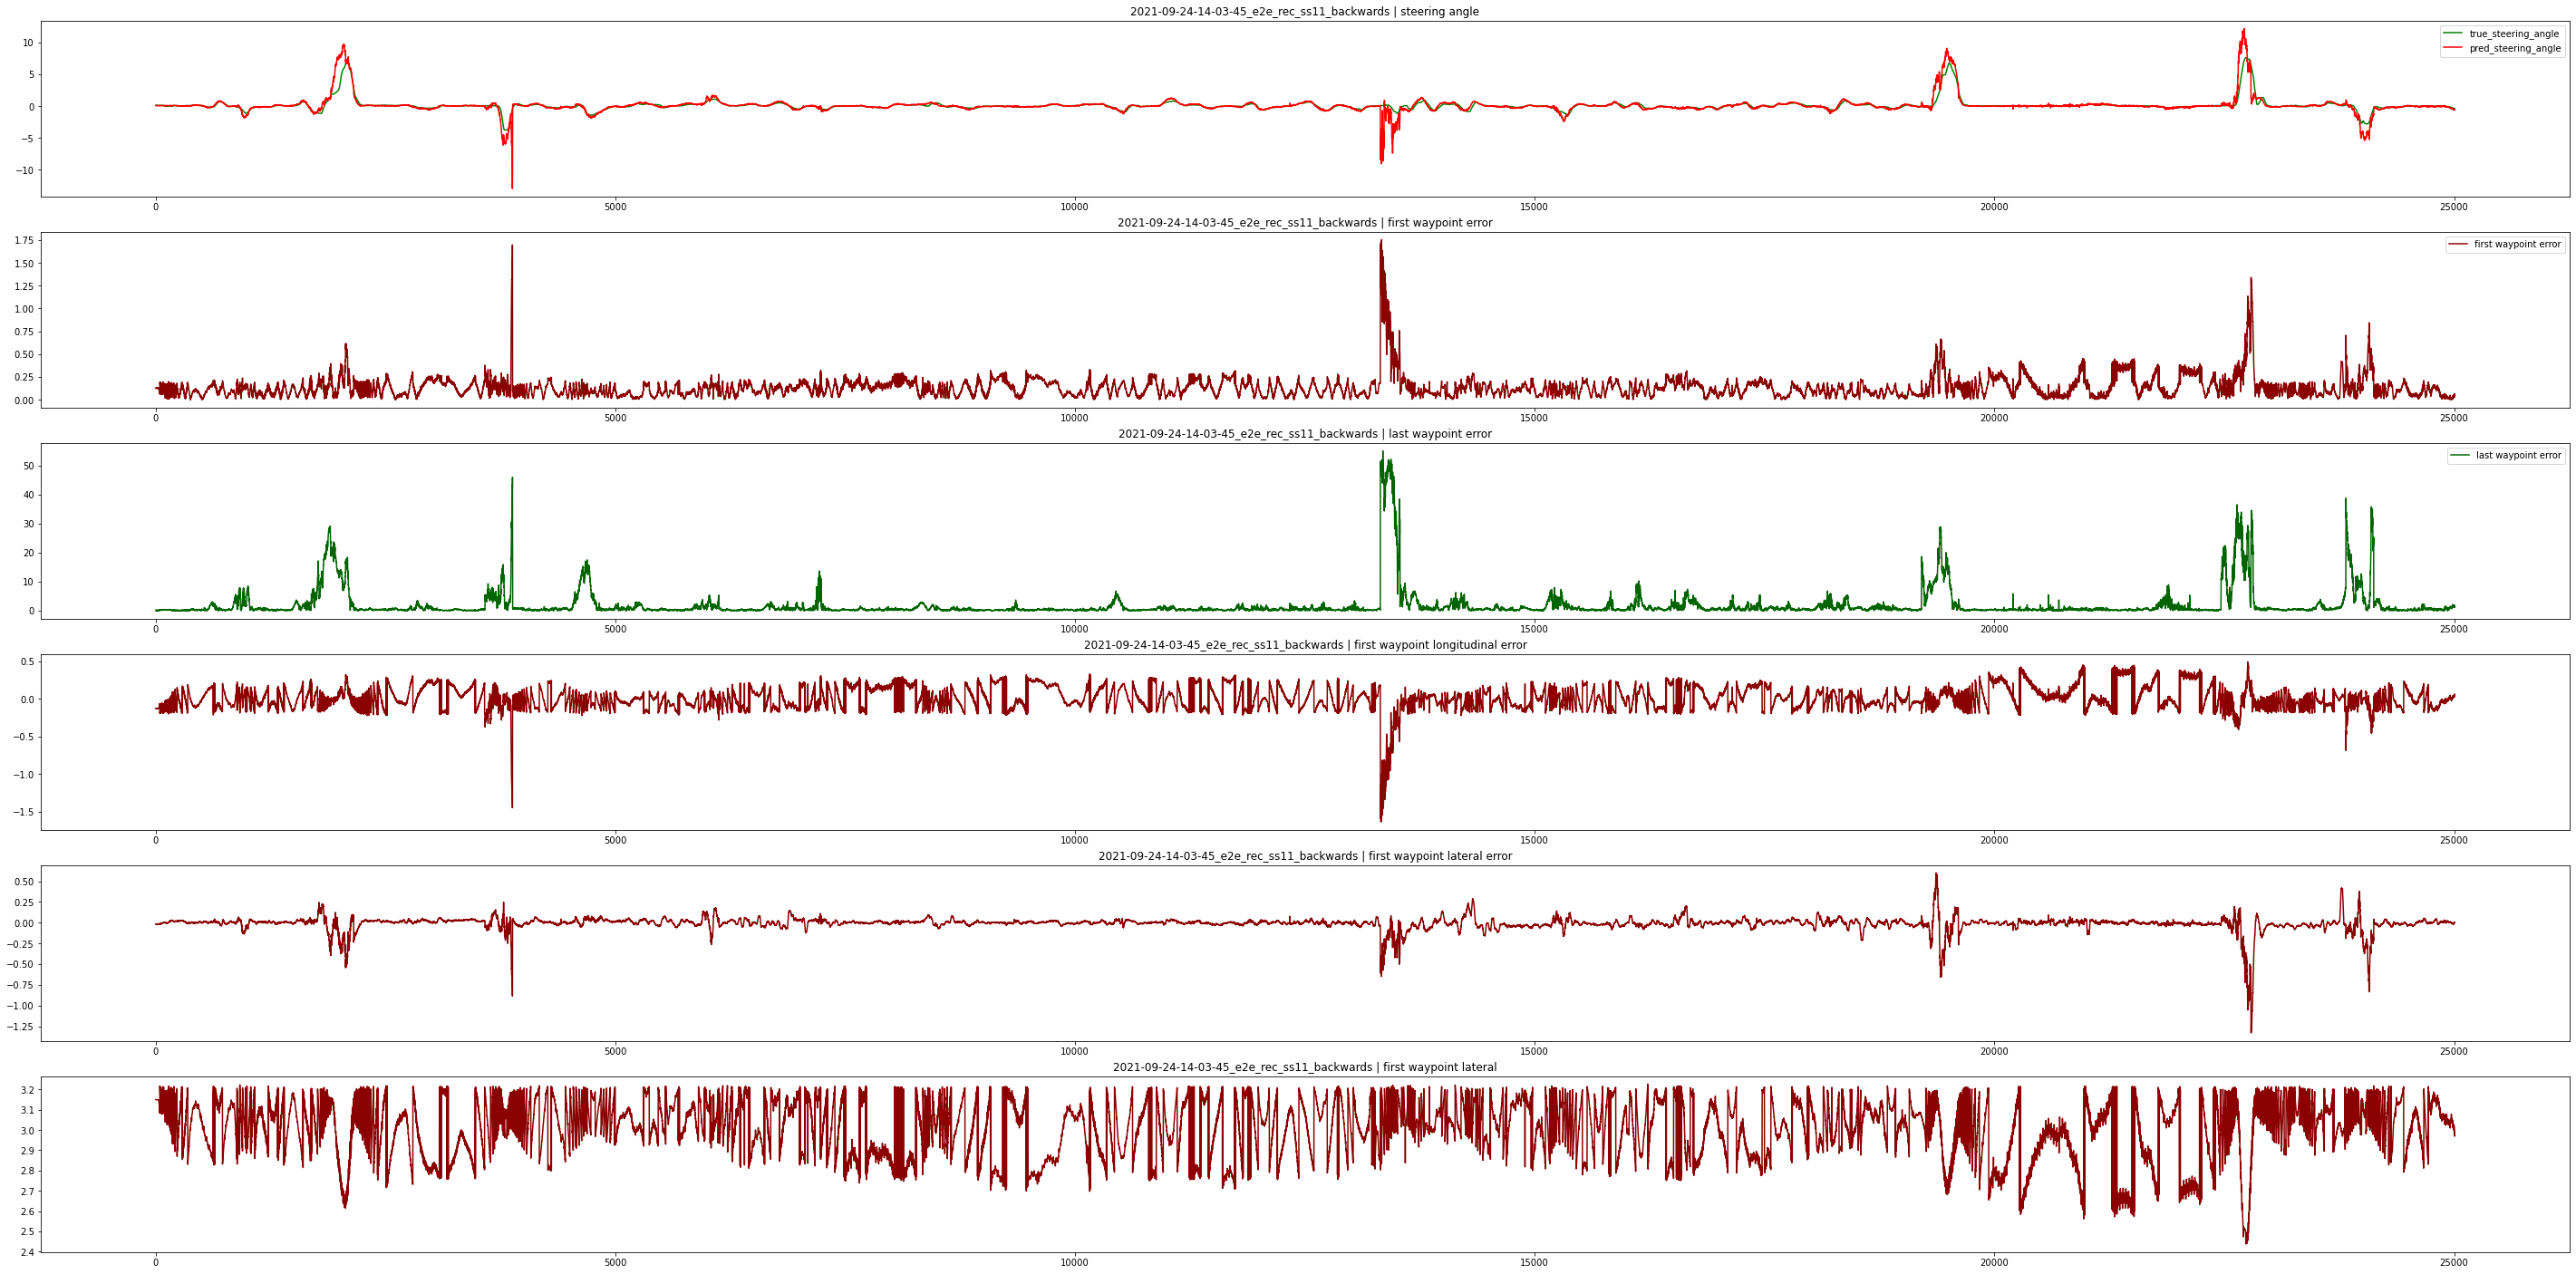

In [35]:
conditional_model = create_model_conditional('20220525165113_waypoints-center-cam', n_branches=3, n_outputs=20)
conditional_trainer = ConditionalTrainer()
create_waypoint_error_plot(conditional_model, conditional_trainer, dataset_name, n_waypoints=10)

In [ ]:
create_waypoint_error_plot(control_model, control_trainer, dataset_name, n_waypoints=10)

In [ ]:
control_model2 = create_model_control('20220407233614_control-10-w', n_outputs=20)
create_waypoint_error_plot(control_model2, control_trainer, dataset_name, n_waypoints=10)